In [1]:
with open('Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [2]:
words_list = [doc.strip().split() for doc in texts]

In [3]:
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


In [4]:
total_words = []
for words in words_list:
    total_words.extend(words)

In [5]:
from collections import Counter
c = Counter(total_words)

In [6]:
max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

In [7]:
# 각 단어에 대해서 index 생성하기
words_dic ={}
for index, word in enumerate(common_words):
    words_dic[word]=index+1

In [8]:
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [9]:
from tensorflow.keras.preprocessing import sequence
max_len = 40
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

In [10]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [11]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

In [12]:
len(y_test)

33077

In [13]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [14]:
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 32)) # +1 을 하는 이유, index 번호 0이 포함되었기 때문
model.add(layers.LSTM(32))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 328,418
Trainable params: 328,418
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint_filepath = './temp/checkpoint_lstm_kr'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)

In [18]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[es, mc])

Epoch 1/20
931/931 [==============================] - 16s 15ms/step - loss: 0.3196 - accuracy: 0.8625 - val_loss: 0.2670 - val_accuracy: 0.8891
Epoch 2/20
931/931 [==============================] - 14s 15ms/step - loss: 0.2394 - accuracy: 0.9029 - val_loss: 0.2605 - val_accuracy: 0.8910
Epoch 3/20
931/931 [==============================] - 13s 14ms/step - loss: 0.2252 - accuracy: 0.9089 - val_loss: 0.2482 - val_accuracy: 0.8973
Epoch 4/20
931/931 [==============================] - 13s 14ms/step - loss: 0.2145 - accuracy: 0.9136 - val_loss: 0.2485 - val_accuracy: 0.8968
Epoch 5/20
931/931 [==============================] - 14s 15ms/step - loss: 0.2063 - accuracy: 0.9175 - val_loss: 0.2393 - val_accuracy: 0.9016
Epoch 6/20
931/931 [==============================] - 14s 15ms/step - loss: 0.1988 - accuracy: 0.9206 - val_loss: 0.2409 - val_accuracy: 0.9024
Epoch 7/20
931/931 [==============================] - 14s 15ms/step - loss: 0.1917 - accuracy: 0.9236 - val_loss: 0.2401 - val_accuracy:

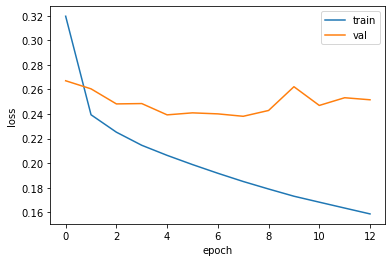

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_acc:', test_acc)

1034/1034 [==============================] - 3s 3ms/step - loss: 0.2347 - accuracy: 0.9049
test_acc: 0.9048583507537842


In [23]:
model.predict(X_test[1:2])

1/1 [==============================] - 0s 426ms/step


array([[0.96136814, 0.03863183]], dtype=float32)

In [24]:
y_test[1]

array([1., 0.], dtype=float32)

In [25]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 7475,  155,  343,  341,
        251,  105, 1945,  477,  192,  106,  251,   10,  907,  190,  223,
         13,   53,    9,    2,  702,   13,  879])

In [26]:
words_dict_reverse = dict((v,k) for k,v in words_dic.items())

In [27]:
def get_original_text(indexed_text):
    original_text = []
    for k in list(indexed_text):
        if k > 0:
            original_text.append(words_dict_reverse[k])
    return ' '.join(original_text)

In [28]:
get_original_text(X_test[1])

'뭐 딴 영화 있지 점주 기능 있었 좋 평점 믿고 보면 큰 친 깨닫 해주는 영화'